In [4]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np

In [5]:
!mkdir tmp

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O tmp/irish-lyrics-eof.txt

--2020-03-05 10:51:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘tmp/irish-lyrics-eof.txt’

tmp/irish-lyrics-eo 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2020-03-05 10:51:21 (82.5 MB/s) - ‘tmp/irish-lyrics-eof.txt’ saved [68970/68970]



##Tokenize the whole corpus

In [6]:
tokenizer = Tokenizer()

data = open('tmp/irish-lyrics-eof.txt').read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1 #plus one <OOV>

print("total words:", total_words)
print(tokenizer.word_index)
#print(corpus)

total words: 2690
{'the': 1, 'and': 2, 'i': 3, 'to': 4, 'a': 5, 'of': 6, 'my': 7, 'in': 8, 'me': 9, 'for': 10, 'you': 11, 'all': 12, 'was': 13, 'she': 14, 'that': 15, 'on': 16, 'with': 17, 'her': 18, 'but': 19, 'as': 20, 'when': 21, 'love': 22, 'is': 23, 'your': 24, 'it': 25, 'will': 26, 'from': 27, 'by': 28, 'they': 29, 'be': 30, 'are': 31, 'so': 32, 'he': 33, 'old': 34, 'no': 35, 'oh': 36, 'ill': 37, 'at': 38, 'one': 39, 'his': 40, 'there': 41, 'were': 42, 'heart': 43, 'down': 44, 'now': 45, 'we': 46, 'where': 47, 'young': 48, 'never': 49, 'go': 50, 'come': 51, 'then': 52, 'did': 53, 'not': 54, 'said': 55, 'away': 56, 'their': 57, 'sweet': 58, 'them': 59, 'green': 60, 'if': 61, 'take': 62, 'our': 63, 'like': 64, 'night': 65, 'day': 66, 'o': 67, 'out': 68, 'fair': 69, 'this': 70, 'town': 71, 'have': 72, 'can': 73, 'true': 74, 'its': 75, 'thou': 76, 'see': 77, 'dear': 78, 'more': 79, 'theres': 80, 'or': 81, 'had': 82, 'would': 83, 'over': 84, 'hear': 85, 'up': 86, 'ive': 87, 'through':

In [7]:
print(tokenizer.texts_to_sequences([corpus[0]])[0])
print(tokenizer.texts_to_sequences([corpus[0]]))

[51, 12, 96, 1217, 48, 2, 69]
[[51, 12, 96, 1217, 48, 2, 69]]


##Generate x y data set

In [0]:
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]

ys = tf.keras.utils.to_categorical(labels, num_classes=total_words) #make the y one-hot encoded

In [9]:
print(tokenizer.word_index['in'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['town'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['athy'])
print(tokenizer.word_index['one'])

8
1
71
6
713
39


In [10]:
print(xs[0])
print(xs[1])
print(xs[2])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 51]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 51 12]
[ 0  0  0  0  0  0  0  0  0  0  0  0 51 12 96]


##Make the model

In [11]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1)) #minus 1 because it's word generation
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))

adam = Adam(lr=0.01) #tune the learning rate
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           269000    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (N

##Train the model

In [12]:
#earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(xs, ys, epochs=100, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 12038 samples
Epoch 1/100
12038/12038 [==============================] - 29s 2ms/sample - loss: 6.6231 - acc: 0.0754
Epoch 2/100
12038/12038 [==============================] - 25s 2ms/sample - loss: 5.7367 - acc: 0.1138
Epoch 3/100
12038/12038 [==============================] - 25s 2ms/sample - loss: 4.8882 - acc: 0.1636
Epoch 4/100
12038/12038 [==============================] - 26s 2ms/sample - loss: 4.0343 - acc: 0.2320
Epoch 5/100
12038/12038 [==============================] - 26s 2ms/sample - loss: 3.2428 - acc: 0.3224
Epoch 6/100
12038/12038 [==============================] - 25s 2ms/sample - loss: 2.6367 - acc: 0.4150
Epoch 7/100
12038/12038 [==============================] - 25s 2ms/sample - loss: 2.1833 - acc: 0.4946
Epoch 8/100
12038/12038 [==============================] - 25s 2ms/sample - loss: 1.9639 - acc: 0.5411
Epoch 9/100
12038/12038 [==============================] - 

In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

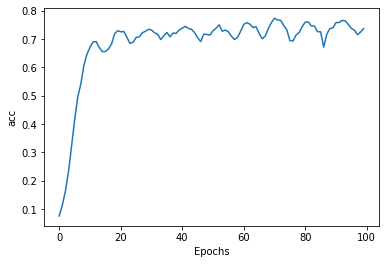

In [14]:
plot_graphs(history, 'acc')

##Test the model

In [15]:
seed_text = "I've got a bad feeling about this"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

I've got a bad feeling about this londons a man who doesnt love me right say i love die than live single on gone gone gone gone gone gone gone here reflections tough corporal casey her chords gone alas whos the ceiling gone more dozen right gone and gone and love can easy gone alone down and gone by love the pots ones coaxin gone the city where the old woman gone gone and gone and by love shall only only died each alone began loud lamenting eyes glisten gone gone by until cursing sinking judge or writin on kilgary mountain valley love wid his flute love
